If you are interested in graident boosting, here is a good place to start: https://xgboost.readthedocs.io/en/latest/tutorials/model.html

This is a supervised machine learning method.

# Predicting PorPerm

In [3]:
!pip install catboost
!pip install scikit-learn --upgrade

     |████████████████████████████████| 65.8MB 93kB/s 
     |████████████████████████████████| 22.2MB 61.9MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [4]:
# If you have installation questions, please reach out
import seaborn as sns
import pandas as pd # data storage
import catboost as cats # graident boosting 

from catboost import CatBoostRegressor, Pool

import numpy as np  # math and stuff
import matplotlib.pyplot as plt # plotting utility
import sklearn # ML and stats

print('catboost ver:', cats.__version__)
print('scikit ver:', sklearn.__version__)

import datetime

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import max_error, mean_squared_error, median_absolute_error


catboost ver: 0.24.4
scikit ver: 0.24.1


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv('drive/My Drive/1_lewis_research/core_to_wl_merge/Merged_dataset_inner_imputed_12_21_2020.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'LiveTime2','ScanTime2', 'LiveTime1','ScanTime1',
              'ref_num', 'API', 'well_name', 'sample_num' ], axis=1)

print(df.columns.values) # printing all column names

df.describe()

['depth_ft' 'USGS_ID' 'CAL' 'GR' 'DT' 'SP' 'DENS' 'PE' 'RESD' 'PHIN'
 'PHID' 'PE_smooth' 'GR_smooth' 'gz_linear_interp' 'gz_pchip_interp'
 'perm_air_md' 'perm_klink_md' 'He_por' 'horz_perm_md' 'effective_por'
 'por_percent' 'stress_swanson_perm_md' 'sample' 'Na' 'Na Err' 'Mg'
 'Mg Err' 'Al' 'Al Err' 'Si' 'Si Err' 'P' 'P Err' 'S' 'S Err' 'K' 'K Err'
 'Ca' 'Ca Err' 'Ti' 'Ti Err' 'Cr' 'Cr Err' 'Mn' 'Mn Err' 'Fe' 'Fe Err'
 'Co' 'Co Err' 'Ni' 'Ni Err' 'Cu' 'Cu Err' 'Zn' 'Zn Err' 'Ba' 'Ba Err']


,depth_ft,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,PE_smooth,GR_smooth,gz_linear_interp,gz_pchip_interp,perm_air_md,perm_klink_md,He_por,horz_perm_md,effective_por,por_percent,stress_swanson_perm_md,Na,Na Err,Mg,Mg Err,Al,Al Err,Si,Si Err,P,P Err,S,S Err,K,K Err,Ca,Ca Err,Ti,Ti Err,Cr,Cr Err,Mn,Mn Err,Fe,Fe Err,Co,Co Err,Ni,Ni Err,Cu,Cu Err,Zn,Zn Err,Ba,Ba Err
count,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,508.000000,510.000000,510.000000,25.000000,25.000000,24.000000,24.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.0,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000
mean,5397.863358,0.468406,0.325999,0.430844,0.811259,0.613371,0.351642,1.011018,0.172737,0.172737,0.351702,0.326029,4.913576,4.910244,81.002187,73.797216,14.267039,8.304000,11.808000,8.420833,1.646585,1.132042,0.025387,0.762913,0.011739,3.490170,0.012272,32.981494,0.033185,0.048516,0.001821,0.728955,0.002247,1.675288,0.005710,2.779623,0.005543,0.190546,0.001373,0.005787,0.000116,0.016520,0.000705,1.941109,0.003196,0.001315,0.0,0.004773,0.000100,0.003211,0.000822,0.006309,0.000763,0.090289,0.004689
std,5106.156677,0.191316,0.237404,0.263514,0.162843,0.214604,0.186912,1.503608,0.226664,0.226664,0.178735,0.229901,1.738128,1.751499,173.917355,161.251984,9.365678,3.161814,4.446902,3.050728,3.741652,0.777851,0.004405,0.488501,0.002843,1.415185,0.002607,4.940991,0.002003,0.023636,0.000221,0.795110,0.001252,0.761818,0.001383,2.045850,0.002189,0.088087,0.000297,0.002270,0.000075,0.024982,0.000128,1.472163,0.001193,0.000821,0.0,0.000796,0.000002,0.004429,0.000114,0.004559,0.000100,0.065308,0.000594
min,150.000000,0.000000,0.000000,0.003752,0.000000,0.000000,0.000000,-0.744314,0.000570,0.000570,0.004477,0.000258,1.204296,1.199972,0.001000,0.000000,1.000000,1.900000,5.900000,4.000000,0.000390,0.126200,0.016000,0.047000,0.006800,0.992200,0.007100,8.429500,0.021700,0.000000,0.001100,0.040300,0.000600,0.118400,0.002000,0.133500,0.001400,0.048500,0.000800,0.000000,-0.001200,0.000000,0.000500,0.270700,0.001300,0.000200,0.0,0.002700,0.000100,0.000000,0.000200,0.000000,0.000500,0.000000,0.003100
25%,450.725000,0.360072,0.122318,0.174146,0.743878,0.424460,0.216157,-0.037336,0.004595,0.004595,0.220800,0.131058,3.538724,3.531571,0.040750,0.020250,8.300000,7.900000,8.400000,6.800000,0.001140,0.768500,0.023400,0.293850,0.009100,2.411025,0.010200,29.728050,0.032000,0.032400,0.001700,0.182225,0.001200,1.069725,0.004600,1.103025,0.003600,0.121875,0.001100,0.004400,0.000100,0.003200,0.000600,0.964250,0.002300,0.000700,0.0,0.004300,0.000100,0.000000,0.000700,0.002700,0.000700,0.053200,0.004300
50%,1614.650000,0.554827,0.275825,0.471657,0.867010,0.605516,0.329327,0.795008,0.005532,0.005532,0.337049,0.283192,4.307541,4.256191,0.065500,0.037500,9.300000,9.500000,10.600000,7.300000,0.002070,1.057300,0.025200,0.692000,0.011700,3.133250,0.011700,31.893100,0.033300,0.047250,0.001800,0.461450,0.001900,1.560450,0.005800,2.593250,0.005700,0.160300,0.001300,0.005400,0.000100,0.014200,0.000700,1.658800,0.003100,0.001200,0.0,0.004800,0.000100,0.000000,0.000800,0.005400,0.000800,0.079300,0.004700
75%,9649.575000,0.602566,0.530980,0.662807,0.925012,0.830179,0.470706,1.378387,0.332503,0.332503,0.463317,0.525448,6.615175,6.633493,71.375000,59.675000,26.610000,10.300000,13.800000,9.200000,0.949777,1.322750,0.026700,1.192400,0.014400,4.531475,0.014400,37.944075,0.034700,0.061800,0.002000,0.941100,0.002900,2.291400,0.006900,3.872700,0.007000,0.258025,0.001600,0.006800,0.000100,0.023400,0.000800,2.616775,0.003900,0.001700,0.0,0.005200,0.000100,0.006300,0.000900,0.009200,0.0

In [8]:
df = df[df.He_por >= 0]

In [9]:
df.describe()

,depth_ft,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,PE_smooth,GR_smooth,gz_linear_interp,gz_pchip_interp,perm_air_md,perm_klink_md,He_por,horz_perm_md,effective_por,por_percent,stress_swanson_perm_md,Na,Na Err,Mg,Mg Err,Al,Al Err,Si,Si Err,P,P Err,S,S Err,K,K Err,Ca,Ca Err,Ti,Ti Err,Cr,Cr Err,Mn,Mn Err,Fe,Fe Err,Co,Co Err,Ni,Ni Err,Cu,Cu Err,Zn,Zn Err,Ba,Ba Err
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,508.000000,510.000000,510.000000,0.0,0.0,0.0,0.0,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.0,278.000000,2.780000e+02,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000
mean,7867.600980,0.382282,0.179142,0.377466,0.778869,0.649789,0.256971,1.495353,0.265479,0.265479,0.257969,0.178263,3.689109,3.682660,81.002187,73.797216,14.267039,NaN,NaN,NaN,NaN,1.235203,0.023721,0.268963,0.008699,2.855647,0.011083,38.274720,0.034292,0.040123,0.001753,0.237229,0.001338,0.997110,0.004357,1.506971,0.003673,0.124190,0.001156,0.005897,0.000138,0.005518,0.000647,0.930934,0.002183,0.000698,0.0,0.004577,1.000000e-04,0.000256,0.000742,0.002947,0.000723,0.096048,0.004566
std,5033.378062,0.205618,0.175484,0.246866,0.169735,0.226908,0.184102,2.004077,0.213216,0.213216,0.175842,0.162409,0.870278,0.882865,173.917355,161.251984,9.365678,NaN,NaN,NaN,NaN,0.555896,0.003559,0.193543,0.001319,0.823285,0.001488,3.392773,0.001691,0.016370,0.000205,0.174879,0.000431,0.439481,0.000859,2.001560,0.001986,0.043739,0.000145,0.002342,0.000058,0.009698,0.000079,0.583494,0.000592,0.000357,0.0,0.000469,4.073090e-19,0.001415,0.000070,0.002076,0.000067,0.071448,0.000438
min,157.200000,0.026503,0.000000,0.026835,0.185083,0.002306,0.000098,-0.731287,0.003645,0.003645,0.004730,0.000285,1.818713,1.803624,0.001000,0.000000,1.000000,NaN,NaN,NaN,NaN,0.409700,0.016000,0.078000,0.007000,1.094000,0.007600,24.356200,0.027700,0.003000,0.001300,0.040300,0.000700,0.265000,0.002500,0.148400,0.001600,0.050000,0.000900,0.000000,-0.000300,0.000000,0.000500,0.272300,0.001300,0.000300,0.0,0.003300,1.000000e-04,0.000000,0.000600,0.000000,0.000500,0.013700,0.003700
25%,875.500000,0.179520,0.054419,0.187125,0.710497,0.433252,0.129545,-0.044952,0.006060,0.006060,0.132651,0.061789,3.211728,3.212229,0.040750,0.020250,8.300000,NaN,NaN,NaN,NaN,1.012700,0.022600,0.150275,0.007900,2.556875,0.010600,37.809275,0.033900,0.029050,0.001600,0.137250,0.001000,0.778200,0.003900,0.502150,0.002500,0.101700,0.001100,0.004400,0.000100,0.000000,0.000600,0.656325,0.001900,0.000500,0.0,0.004300,1.000000e-04,0.000000,0.000700,0.001500,0.000700,0.054200,0.004300
50%,9440.200000,0.413325,0.119408,0.297110,0.830718,0.746584,0.216451,1.054603,0.268676,0.268676,0.216275,0.126171,3.621850,3.620200,0.065500,0.037500,9.300000,NaN,NaN,NaN,NaN,1.310550,0.024150,0.198100,0.008300,2.912600,0.011250,39.436500,0.034700,0.037000,0.001700,0.179600,0.001200,0.989700,0.004400,0.727550,0.003000,0.119350,0.001100,0.005300,0.000100,0.001200,0.000600,0.813300,0.002100,0.000600,0.0,0.004550,1.000000e-04,0.000000,0.000700,0.002500,0.000700,0.073700,0.004500
75%,10295.750000,0.594764,0.241328,0.632071,0.903156,0.837204,0.328656,1.891132,0.430926,0.430926,0.343879,0.248199,3.857325,3.849729,71.375000,59.675000,26.610000,NaN,NaN,NaN,NaN,1.450950,0.025175,0.315550,0.009100,3.129675,0.011700,40.037800,0.035300,0.047100,0.001800,0.284175,0.001500,1.126125,0.004700,1.174350,0.003675,0.138200,0.001200,0.006600,0.000200,0.005650,0.000700,0.989900,0.002300,0.000700,0.0,0.004800,1.000000e-04,0.000000,0.000800,0.003900,0.000700,0.109950,0.004800
max,13584.000000,0.611344,0.911408,0.963093,0.999890,0.954558,0.934521,8.924409,0.998360,0.998360,0.881915,0.826759,7.589500,7.589500,994.000000,936.000000,32

In [10]:
df = df[df.USGS_ID != 'E997']

## Loading in dataset

In [11]:
dataset = df[[
       'CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
       'RESD', 'PHIN', 'PHID', 
       'GR_smooth', 
       'PE_smooth','He_por'
]]

In the next code block, we will remove the rows without data, and change string NaN's to np.nans

In [12]:
dataset.replace('NaN',np.nan, regex=True, inplace=True)# 
#dataset = dataset.dropna()
np.shape(dataset)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


(357, 12)

In [13]:
dataset.head(3)

,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,GR_smooth,PE_smooth,He_por
1229,0.554827,0.106534,0.062840,0.428129,0.640543,0.142615,7.794016,0.443457,0.443457,0.079817,0.168882,8.0
1240,0.554827,0.112556,0.056922,0.438185,0.655566,0.218843,7.794016,0.385185,0.385185,0.094562,0.190306,7.9
1250,0.554827,0.066613,0.062503,0.451586,0.640814,0.223560,7.066365,0.430617,0.430617,0.102731,0.196158,7.9


In [14]:
X = dataset[['CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
        'RESD', 'PHIN', 'PHID', 
        'GR_smooth', 
        'PE_smooth']]

Y = dataset[['He_por']]

Y_array = np.array(Y.values)

## Starting to set up the ML model params

In [15]:
seed = 7 # random seed is only used if you want to compare exact answers with friends 
test_size = 0.25 # how much data you want to withold, .15 - 0.3 is a good starting point

X_train, X_test, y_train, y_test = train_test_split(X.values, Y_array, test_size=test_size)

### Let's try some hyperparameter tuning (this takes forever!)

Hyperparameter testing does a grid search to find the best parameters, out of the parameters below. This turned out to be really slow on my laptop. Please skip this! 

In [16]:
model = CatBoostRegressor(objective='RMSE', iterations=2000)

model.fit(X_train, y_train, verbose=500 )

preds = model.predict(X_test)

rmse = mean_squared_error(y_test, preds, squared=False)
print("Root Mean Squared Error: %f" % (rmse))
max = max_error(y_test, preds)
print("Max Error: %f" % (max))

MAE = median_absolute_error(y_test, preds)
print("Median Abs Error: %f" % (MAE))

Learning rate set to 0.01822
0:	learn: 1.9598792	total: 49ms	remaining: 1m 37s
500:	learn: 0.8573774	total: 1.03s	remaining: 3.07s
1000:	learn: 0.5146079	total: 1.98s	remaining: 1.97s
1500:	learn: 0.3378731	total: 2.96s	remaining: 985ms
1999:	learn: 0.2370094	total: 3.91s	remaining: 0us
Root Mean Squared Error: 1.534459
Max Error: 5.680464
Median Abs Error: 0.761464


In [17]:
grid = {'learning_rate': [ 0.05, 0.1, 0.2, 0.3],
        'depth': [ 2, 4, 6, 8, 10],
        'l2_leaf_reg': [1, 2, 3, 4, 5, 7]}

model_grid = CatBoostRegressor(objective='RMSE', iterations=750)

# Grid Search
grid_search_result = model_grid.grid_search(grid, 
                                            X=X_train, 
                                            y=y_train, 
                                            cv=5,
                                            verbose=False
                                       )


bestTest = 1.589563728
bestIteration = 136


bestTest = 1.59628712
bestIteration = 62


bestTest = 1.572107021
bestIteration = 39


bestTest = 1.565481245
bestIteration = 31


bestTest = 1.572091583
bestIteration = 148


bestTest = 1.546724848
bestIteration = 99


bestTest = 1.559550089
bestIteration = 31


bestTest = 1.547410009
bestIteration = 101


bestTest = 1.601706923
bestIteration = 161


bestTest = 1.527813865
bestIteration = 82


bestTest = 1.530984383
bestIteration = 33


bestTest = 1.564511427
bestIteration = 31


bestTest = 1.59446472
bestIteration = 183


bestTest = 1.575954167
bestIteration = 95


bestTest = 1.613928011
bestIteration = 57


bestTest = 1.597497986
bestIteration = 32


bestTest = 1.601950834
bestIteration = 198


bestTest = 1.566263412
bestIteration = 82


bestTest = 1.584378533
bestIteration = 52


bestTest = 1.587389759
bestIteration = 95


bestTest = 1.591036298
bestIteration = 256


bestTest = 1.542014719
bestIteration = 84


bestTest = 1.63857548
best

In [18]:
grid_search_result['params']

{'depth': 2, 'l2_leaf_reg': 7, 'learning_rate': 0.3}

Now plug in the hyperparameters into the training model.

In [19]:
model2 = CatBoostRegressor(objective='RMSE',
                           depth=grid_search_result['params']['depth'],
                           l2_leaf_reg=grid_search_result['params']['l2_leaf_reg'],
                           learning_rate=grid_search_result['params']['learning_rate'],
                           iterations=200)

model2.fit(X_train, y_train, verbose=50 )

preds2 = model2.predict(X_test)

rmse2 = mean_squared_error(y_test, preds2, squared=False)
print("Root Mean Squared Error: %f" % (rmse2))
max1 = max_error(y_test, preds2)
print("Max Error: %f" % (max1))

MAE2 = median_absolute_error(y_test, preds2)
print("Median Abs Error: %f" % (MAE2))

0:	learn: 1.9143411	total: 718us	remaining: 143ms
50:	learn: 1.2263377	total: 20.4ms	remaining: 59.6ms
100:	learn: 1.0154589	total: 39.7ms	remaining: 39ms
150:	learn: 0.8717878	total: 67.6ms	remaining: 21.9ms
199:	learn: 0.7687132	total: 85.9ms	remaining: 0us
Root Mean Squared Error: 1.622826
Max Error: 5.009704
Median Abs Error: 0.748676


# Exporting

In [20]:
x = datetime.datetime.now()

d = {'target': [Y.columns.values, Y.columns.values],
     'MSE': [rmse, rmse2],
     'MAE': [MAE, MAE2],
     'MaxError': [max, max1], 
     'day': [x.day, x.day], 
     'month':[x.month, x.month], 
     'year':[x.year, x.year],
     'model':['catboost', 'catboost'],
     'version':[cats.__version__, cats.__version__ ]}

results = pd.DataFrame(data=d)

results.to_csv('drive/My Drive/1_lewis_research/analysis/experiments/catboost/catboost_results/por_cat.csv')

results

,target,MSE,MAE,MaxError,day,month,year,model,version
0,[He_por],1.534459,0.761464,5.680464,21,2,2021,catboost,0.24.4
1,[He_por],1.622826,0.748676,5.009704,21,2,2021,catboost,0.24.4


(array([ 7.,  2.,  4.,  8., 14., 22., 38., 95., 64., 13.]),
 array([ 1.  ,  2.05,  3.1 ,  4.15,  5.2 ,  6.25,  7.3 ,  8.35,  9.4 ,
        10.45, 11.5 ]),
 <a list of 10 Patch objects>)

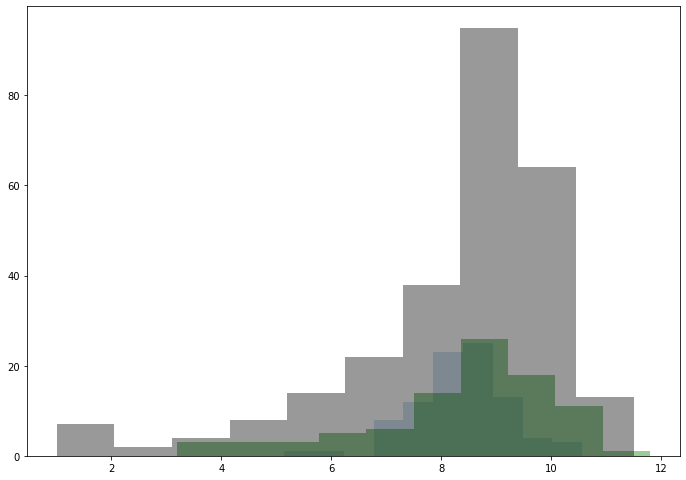

In [28]:
plt.hist(preds2, alpha=0.2, bins = 10)
plt.hist(y_test, alpha=0.4, bins=10, color='g')
plt.hist(y_train, alpha=0.4, bins=10, color='black')

In [22]:
print('y_test:', np.median(y_test))
print('pred:', np.median(preds))
print('y_train:', np.median(y_train))

y_test: 8.8
pred: 8.378780653870054
y_train: 9.0


In [23]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27


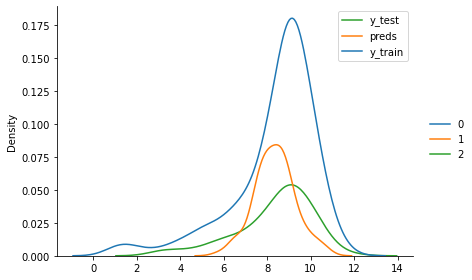

In [24]:

sns.displot([y_train.flatten(), 
             preds.flatten(),
             y_test.flatten()], kind="kde",
            height=4, aspect=6/4)


plt.legend(['y_test', 'preds', 'y_train'])


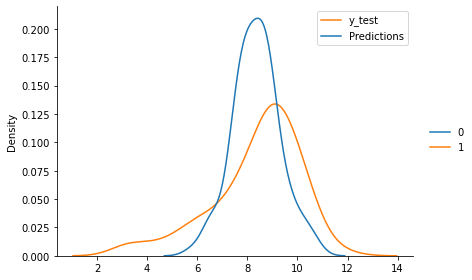

In [25]:
sns.displot([preds.flatten(),
             y_test.flatten()], kind="kde",
            height=4, aspect=6/4)


plt.legend([ 'y_test', 'Predictions'])

(-10.0, 10.0)

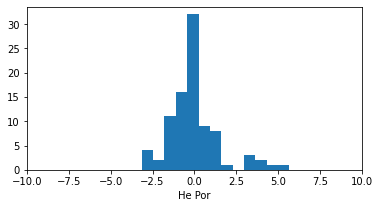

In [26]:
error = preds.flatten() - y_test.flatten()

plt.figure(figsize=(6,3))
plt.hist(error, bins=13)
plt.xlabel('He Por')
plt.xlim((-10,10))

Text(0.5, 0, 'Catboost Feature Importance')

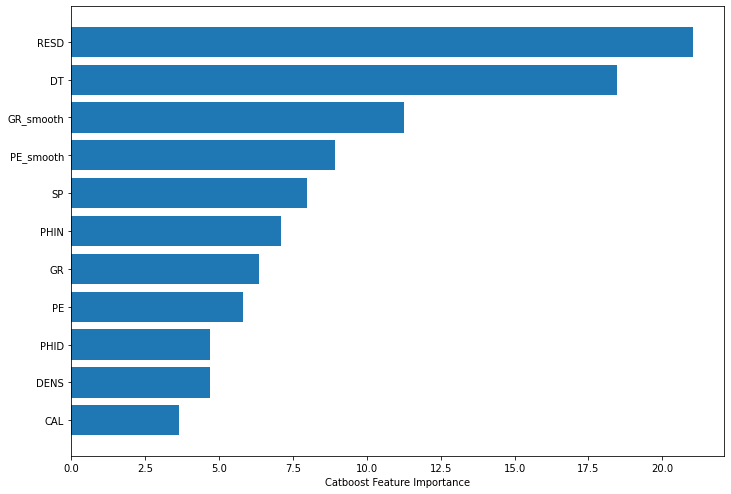

In [27]:
sorted_idx = model2.feature_importances_.argsort()

plt.barh(X.columns[sorted_idx], model2.feature_importances_[sorted_idx])
plt.xlabel("Catboost Feature Importance")